<a href="https://colab.research.google.com/github/vitroid/GenIce-core/blob/main/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## for Google Colaboratory

In [ ]:
%pip install git+https://github.com/vitroid/GenIce-core.git pairlist

## 1. Make an arbitrary graph directed.

In [ ]:
import networkx as nx
import matplotlib
import genice_core

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
dg = genice_core.ice_graph(g)

nx.draw_networkx(dg, pos)

## 2. And depolarized.

In [ ]:
import networkx as nx
import matplotlib
import genice_core
from logging import getLogger, DEBUG, basicConfig, INFO

basicConfig(level=INFO)
logger=getLogger()

g = nx.dodecahedral_graph()  # dodecahedral 20mer
pos = nx.spring_layout(g)

# set orientations of the hydrogen bonds.
# Minimize the net dipole moment.
dg = genice_core.ice_graph(g, pos, dipoleOptimizationCycles=100)

nx.draw_networkx(dg, pos)

## 3. Under the periodic boundary condition.

In [ ]:
from logging import DEBUG, INFO, basicConfig, getLogger

import networkx as nx
import numpy as np

# import py3Dmol
import pairlist
from genice_core import ice_graph

logger = getLogger()
basicConfig(level=INFO)

# a sample structure of ice 1h.
# The first line specifies the cell dimension, and atomic positions (absolute) follows.
pos = np.loadtxt("ice1h.txt").reshape(-1, 3)
cell, coords = pos[0], pos[1:]

# prepare the cell matrix
cellmat = np.diag(cell)

# make the fractional coordinates
fracCoords = coords / cell

# make a graph from the proximity
g = nx.Graph([(i, j) for i, j, _ in pairlist.pairs_iter(fracCoords, 0.3, cellmat)])

# set orientations of the hydrogen bonds.
dg = ice_graph(
    g, vertexPositions=fracCoords, isPeriodicBoundary=True, dipoleOptimizationCycles=100
)
dg

## Benchmark tests

### Scalability

In [3]:
import numpy as np


def diamond(N: int) -> np.ndarray:
    """Diamond lattice. == ice 1c

    Args:
        N (int): Number of unit cells per an edge of the simulation cell.

    Returns:
        np.ndarray: atomic positions in the fractional coordinate.
    """
    # make an FCC
    xyz = (
        np.array(
            [
                (x, y, z)
                for x in range(N)
                for y in range(N)
                for z in range(N)
                if (x + y + z) % 2 == 0
            ]
        )
    )
    xyz = np.vstack([xyz, xyz + 0.5])
    return xyz / N

INFO:root:0.0020248889923095703 sec noodlize()
INFO:root:0.002090930938720703 sec split_into_simple_paths()
INFO:root:0.0033180713653564453 sec noodlize()
INFO:root:0.0016598701477050781 sec split_into_simple_paths()
INFO:root:0.008889913558959961 sec noodlize()
INFO:root:0.0038232803344726562 sec split_into_simple_paths()
INFO:root:0.021923065185546875 sec noodlize()
INFO:root:0.011368036270141602 sec split_into_simple_paths()
INFO:root:0.05575394630432129 sec noodlize()
INFO:root:0.04162192344665527 sec split_into_simple_paths()
INFO:root:0.28677892684936523 sec noodlize()
INFO:root:0.11822891235351562 sec split_into_simple_paths()
INFO:root:0.6177577972412109 sec noodlize()
INFO:root:0.2656681537628174 sec split_into_simple_paths()
INFO:root:1.9251892566680908 sec noodlize()
INFO:root:1.1321980953216553 sec split_into_simple_paths()
INFO:root:3.3681700229644775 sec noodlize()
INFO:root:2.415052652359009 sec split_into_simple_paths()
INFO:root:0.0007750988006591797 sec noodlize()
INF

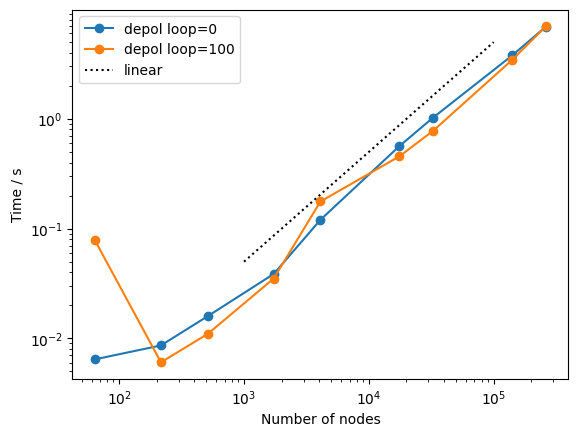

In [4]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt

np.random.seed(999)

for depol in (0, 100):
    X = []
    Y = []
    for N in (4, 6, 8, 12, 16, 26, 32, 52, 64):
        pos = diamond(N)
        cell = np.diag([N, N, N])
        # adjacency graph
        g = nx.Graph(
            [
                (i, j)
                for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
            ]
        )

        now = time.time()
        dg = genice_core.ice_graph(
            g,
            vertexPositions=pos,
            dipoleOptimizationCycles=depol,
        )
        X.append(len(g))
        Y.append(time.time() - now)

    plt.plot(X, Y, "o-", label=f"depol loop={depol}")

plt.xscale("log")
plt.yscale("log")
X = np.logspace(3, 5, 10)
Y = X / 20000
plt.plot(X, Y, "k:", label="linear")
plt.xlabel("Number of nodes")
plt.ylabel("Time / s")
plt.legend()

### Doped ice

Comparison with original GenIce 2.1 using Buch's algorithm.

In [ ]:
%pip install git+https://github.com/vitroid/GenIce.git#2.1.7.1

In [ ]:
! time genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

In [ ]:
! pip install git+https://github.com/vitroid/GenIce.git@genice-core

In [ ]:
! time genice2 1c -r 24 24 24 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

In [ ]:
! pip install py3dmol

In [ ]:
! time genice2 1c -r 4 4 4 --cation 0=Li --anion 10=F --depol=optimal > doped1c.gro

In [ ]:
# なぜか表示されない
import py3Dmol

# show
view = py3Dmol.view()
view.addModel("doped1c.gro")
view.setStyle({'stick':{}})
view.addUnitCell()
view.zoomTo()
view.show()

### Normal ice

Improvement from GenIce2.1

In [ ]:
! pip install git+https://github.com/vitroid/GenIce.git#2.1.7.1
! time genice2 1c -r 30 30 30 > doped1c.gro

In [ ]:
! pip uninstall -y genice2
! pip install git+https://github.com/vitroid/GenIce.git@genice-core
! time genice2 1c -r 30 30 30 > doped1c.gro
! genice2 --version

## Debug and Tuning

In [ ]:
import pairlist as pl
import networkx as nx
import genice_core
import time
import matplotlib.pyplot as plt
from logging import getLogger, INFO, basicConfig

logger = getLogger()
basicConfig(level=INFO)


def main():
    np.random.seed(999)

    N = 64
    pos = diamond(N)
    cell = np.diag([N, N, N])
    # adjacency graph
    g = nx.Graph(
        [
            (i, j)
            for i, j in pl.pairs_iter(pos, 1, cell, fractional=True, distance=False)
        ]
    )

    now = time.time()
    dg = genice_core.ice_graph(
        g,
        vertexPositions=pos,
        dipoleOptimizationCycles=100,
    )


import cProfile

cProfile.run("main()", filename="main.prof")

In [ ]:
import pstats

sts = pstats.Stats("main.prof")
sts.strip_dirs().sort_stats(-1).print_stats()